In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve

c = 3.00e8 # m /s

In [3]:
# Degree of the Ylm expansion
lmax = 10
N = (lmax + 1) ** 2

In [4]:
# Grab the `A1` matrix from `starry`
import starry
map = starry.Map(lmax)
A1 = map.ops.A1.eval()

In [5]:
def Ij(j, gamma):
    """
    
    """
    if j == 0:
        return 0.5 * np.pi * (1 - gamma ** 2)
    else:
        return (j - 1) / (j + 2) * (1 - gamma ** 2) * Ij(j - 2, gamma)

    
def sn(n, xi, wsini):
    """
    
    """
    # This is a vector function!
    xi = np.atleast_1d(xi)
    res = np.zeros_like(xi)
    
    # Indices
    L = np.floor(np.sqrt(n))
    D = 0.5 * (n - L ** 2)
    i = int(np.floor(L - D))
    j = int(np.floor(D))
    k = int(np.ceil(D) - np.floor(D))
    
    # x coordinate of lines of constant Doppler shift
    gamma = c / wsini * (1 - np.exp(xi))
    
    # Integral is only nonzero when we're
    # inside the unit disk
    idx = np.abs(gamma) < 1
    
    # Solve the integral
    if (k == 0) and (j % 2 == 0):
        res[idx] = (2 * gamma[idx] ** i * (1 - gamma[idx] ** 2) ** (0.5 * (j + 1))) / (j + 1)
    elif (k == 1) and (j % 2 == 0):
        res[idx] = gamma[idx] ** i * Ij(j, gamma[idx])
    
    return res


def s(xi, wsini):
    """
    
    """
    res = np.zeros((N, len(xi)))
    for n in range(N):
        res[n] = sn(n, xi, wsini)
    return res


def g(xi, wsini):
    """
    
    """
    # A1 is a sparse scipy matrix, so `*` 
    # is actually how we dot matrices!
    return s(xi, wsini).T * A1

In [6]:
# Grab the Ylm expansion of a Gaussian spot
# from the previous version of starry
import starry_beta
map_beta = starry_beta.Map(lmax)
map_beta.add_gaussian(sigma=0.4, amp=-1.0, lat=30)
alm = np.array(map_beta.y)

In [7]:
# Show the star
map = starry.Map(lmax, lazy=False)
map[1:, :] = alm[1:]
map.show(theta=np.linspace(0, 360, 50))

Compiling `render`... Done.


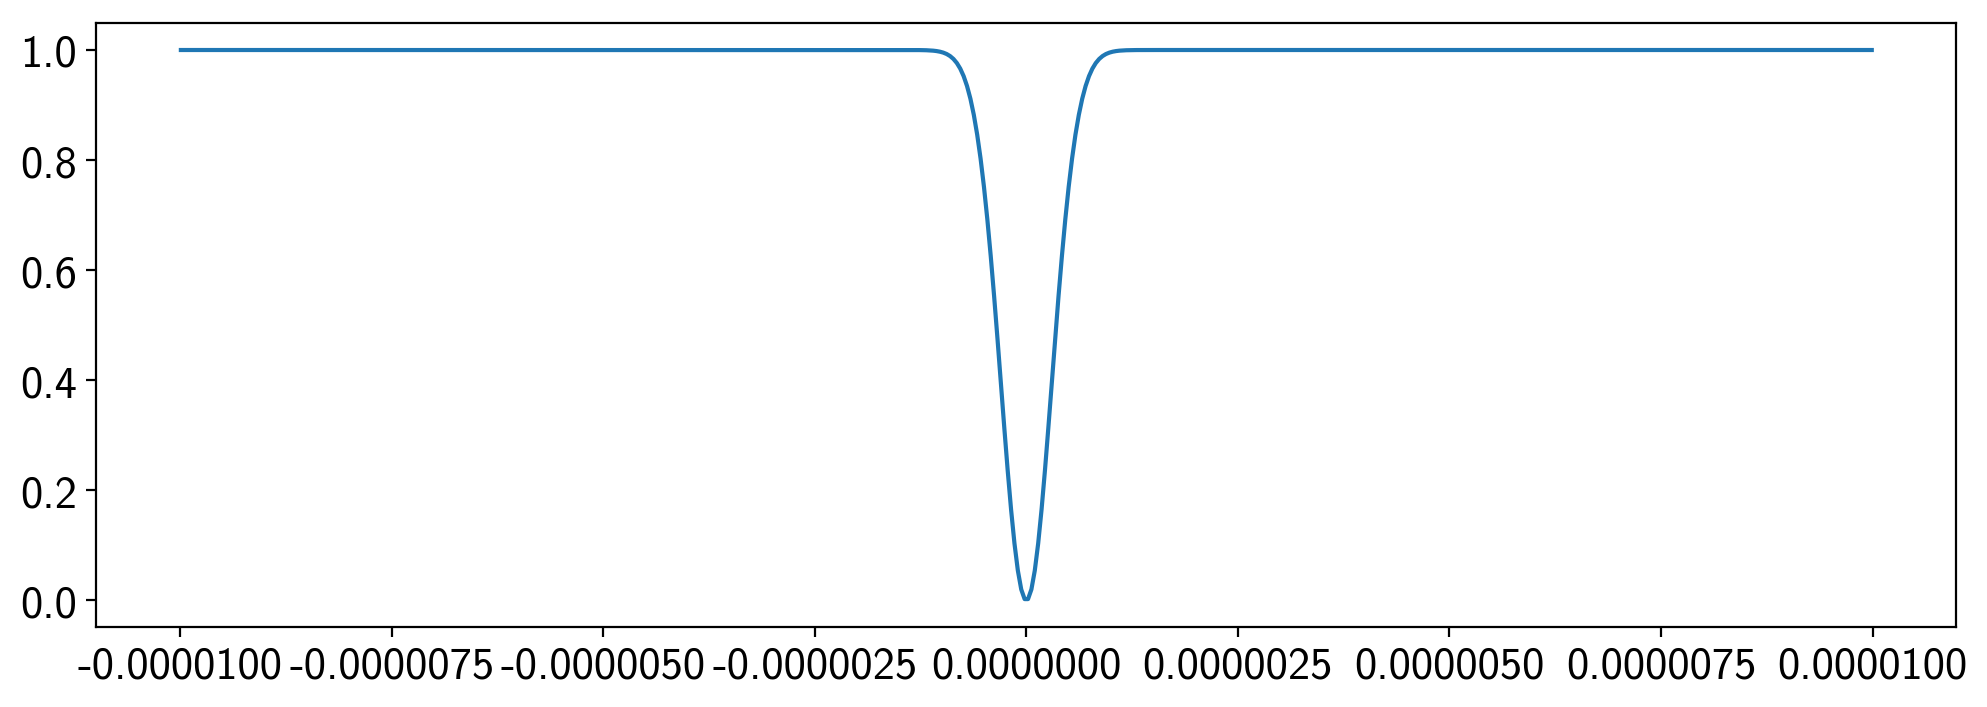

In [26]:
# Log wavelength array
xi = np.linspace(-2e-5, 2e-5, 1000)
dxi = xi[1] - xi[0]
obs = np.abs(xi) < 1e-5

# A gaussian absorption line
amp = 1.0
mu = 0.0
sigma = 3e-7
a0 = 1 - amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)

a = np.dot(alm.reshape(-1, 1), a0.reshape(1, -1))
plt.plot(xi[obs], a0[obs]);

In [46]:
wsini = -5.0e2
maxalpha = np.log(1 - wsini / c)
tau = xi[(xi >= -maxalpha) & (xi <= maxalpha)]
G = g(tau, wsini)

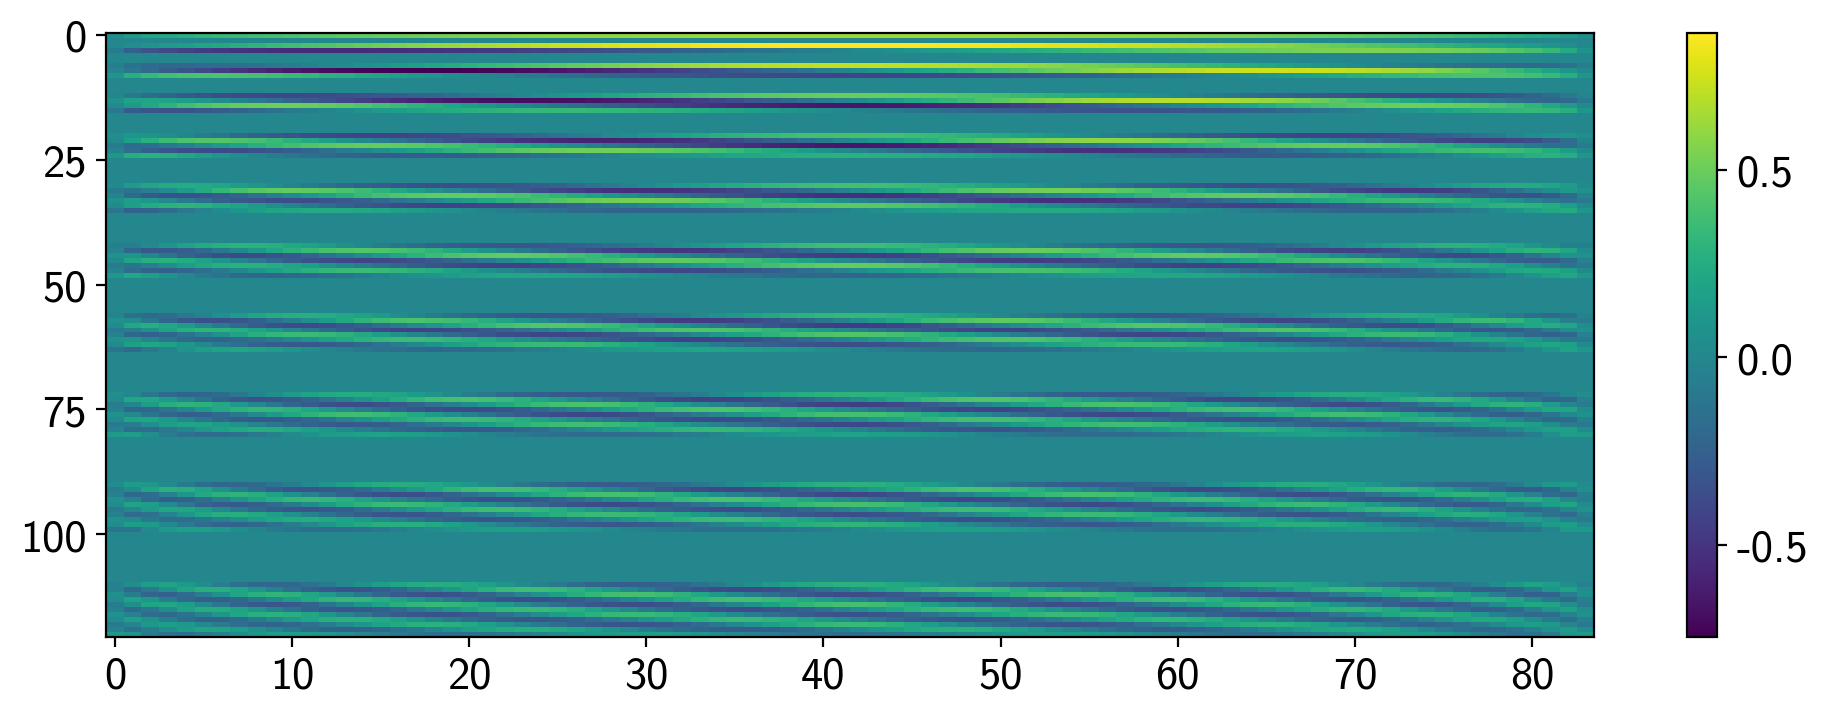

In [47]:
plt.imshow(G.T, aspect='auto')
plt.colorbar();

## Time evolution

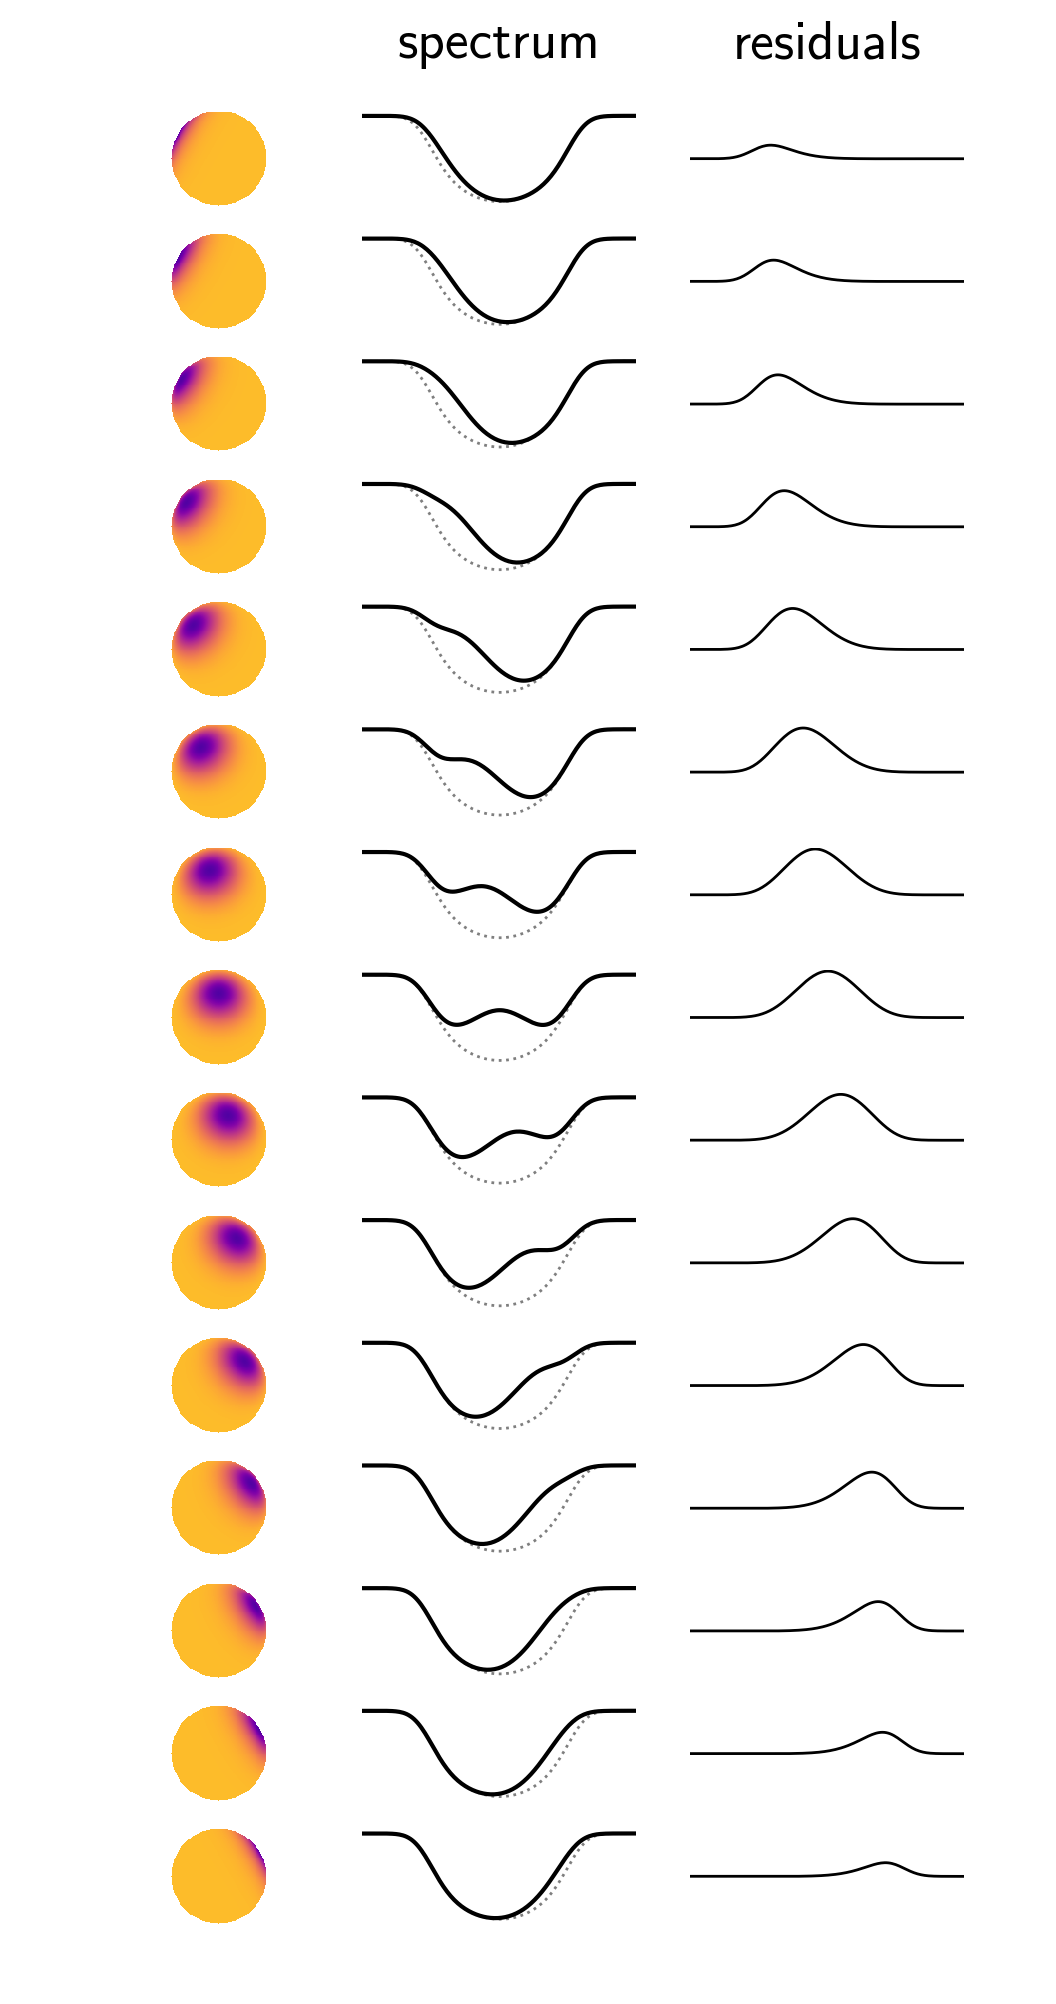

In [80]:
# Get vmin, vmax
map[1:, :] = alm[1:]
img = map.render()
vmin = np.nanmin(img)
vmax = np.nanmax(img)
rng = vmax - vmin
vmin -= 0.2 * rng
vmax += 0.2 * rng

# Compute the spectrum when
# the spot is on the backside
# for reference
map.rotate(180)
a = np.dot(map.y.reshape(-1, 1), a0.reshape(1, -1))
S0 = np.zeros_like(xi)
for n in range(N):
    S0 += convolve(a[n], G[:, n], mode="same")
S0 -= S0[obs][0]

# Let's do it
nt = 15
theta = np.linspace(-90, 90, nt)
fig, ax = plt.subplots(nt, 3, figsize=(6, 12))
fig.subplots_adjust(hspace=0.3)

for t in range(nt):
    # Rotate & compute spectrum
    map[1:, :] = alm[1:]
    map.rotate(theta[t])
    a = np.dot(map.y.reshape(-1, 1), a0.reshape(1, -1))
    S = np.zeros_like(xi)
    for n in range(N):
        S += convolve(a[n], G[:, n], mode="same")
    S -= S[obs][0]
    
    # Plot spectrum
    ax[t, 1].plot(xi[obs], S0[obs], "k:", lw=1, alpha=0.5)
    ax[t, 1].plot(xi[obs], S[obs], "k-")
    ax[t, 1].set_xlim(-0.000003, 0.000003)
    ax[t, 1].axis('off');
    
    # Plot residuals
    ax[t, 2].plot(xi[obs], S[obs] - S0[obs], "k-", lw=1)
    ax[t, 2].set_xlim(-0.000003, 0.000003)
    ax[t, 2].axis('off');
    ax[t, 2].set_ylim(-8.0, 8.0)
    
    # Plot current stellar image
    img = map.render(res=100)[:, :, 0]
    ax[t, 0].imshow(img, origin="lower", 
                    extent=(-1, 1, -1, 1),
                    cmap="plasma", vmin=vmin,
                    vmax=vmax)
    ax[t, 0].set_xlim(-3, 1)
    ax[t, 0].set_ylim(-1, 1)
    ax[t, 0].axis('off');

ax[0, 1].set_title("spectrum", y=1.4);
ax[0, 2].set_title("residuals", y=1.4);

## Compare to numerical

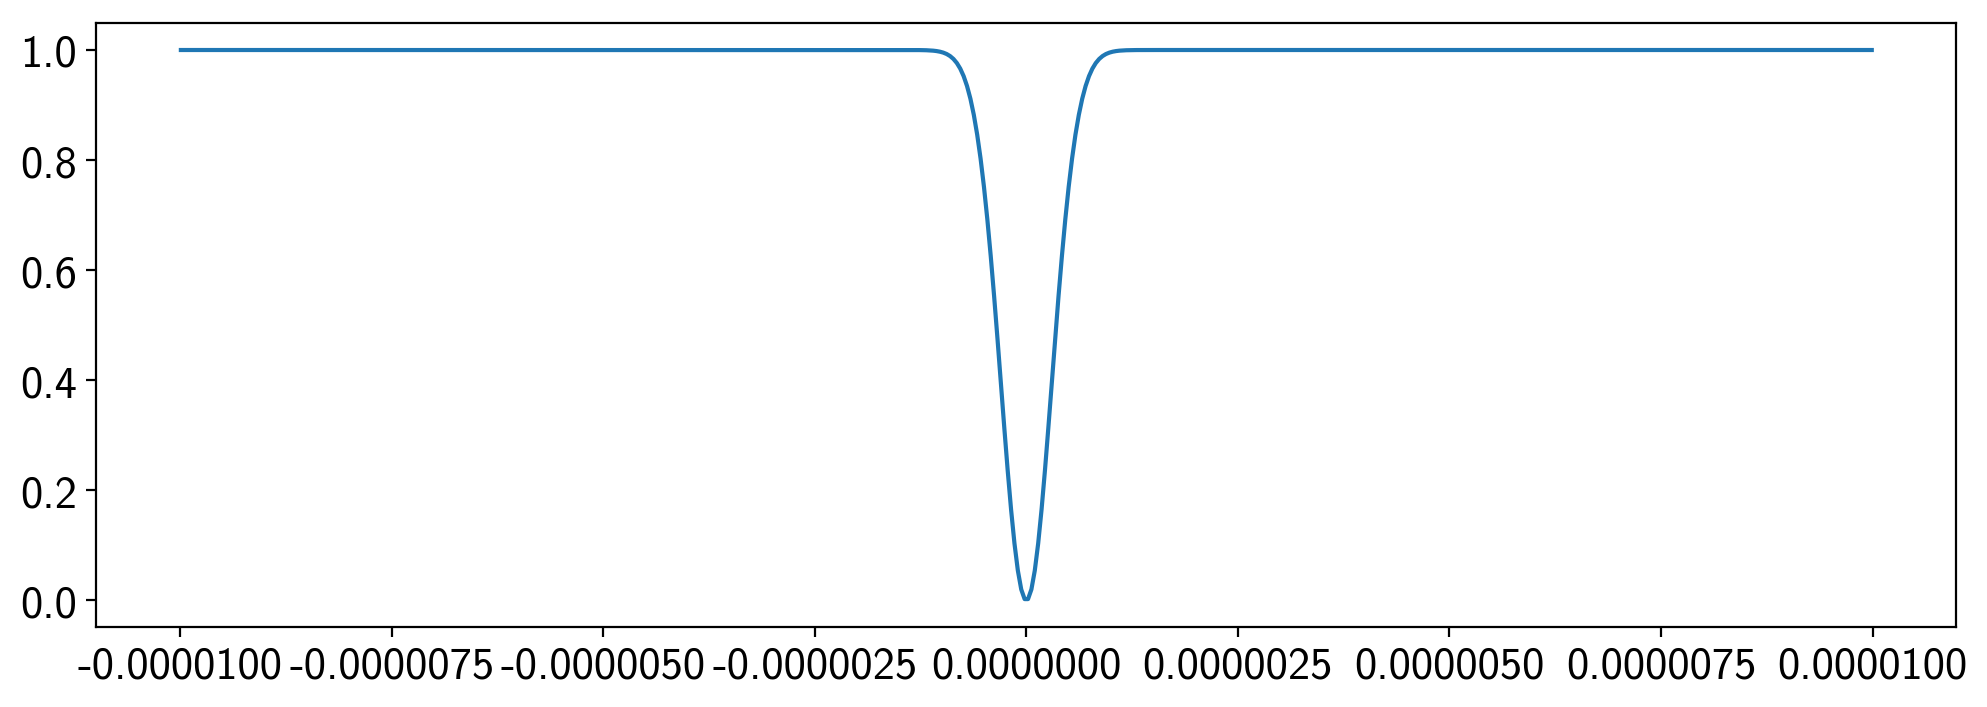

In [81]:
plt.plot(xi[obs], a0[obs]);

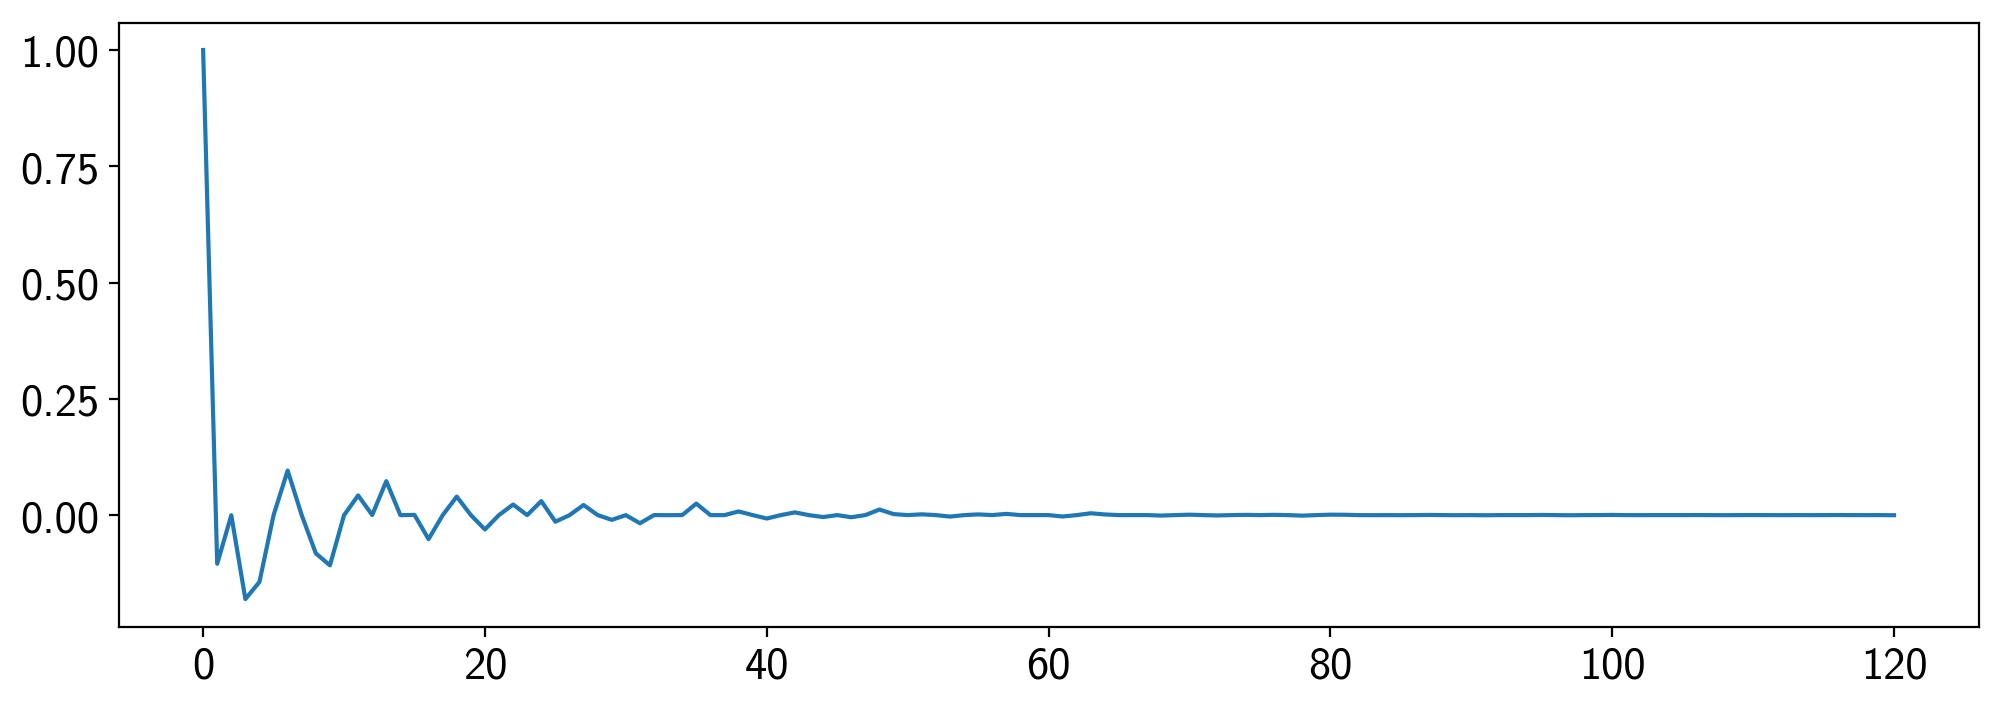

In [86]:
plt.plot(a[:,0])

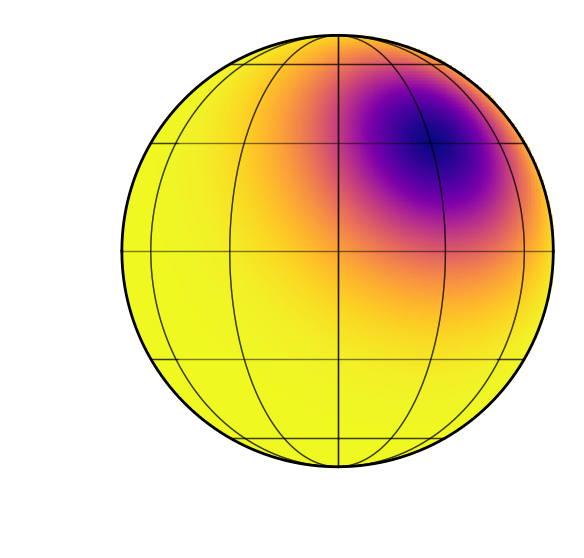

In [90]:
map[1:, :] = alm[1:]
map.rotate(30)
map.show()

a = np.dot(map.y.reshape(-1, 1), a0.reshape(1, -1))

In [116]:
map_s = starry.Map(lmax, nw=1000, lazy=False)

In [117]:
for n in range(1000):
    map_s[1:, :, n] = a[1:, n]

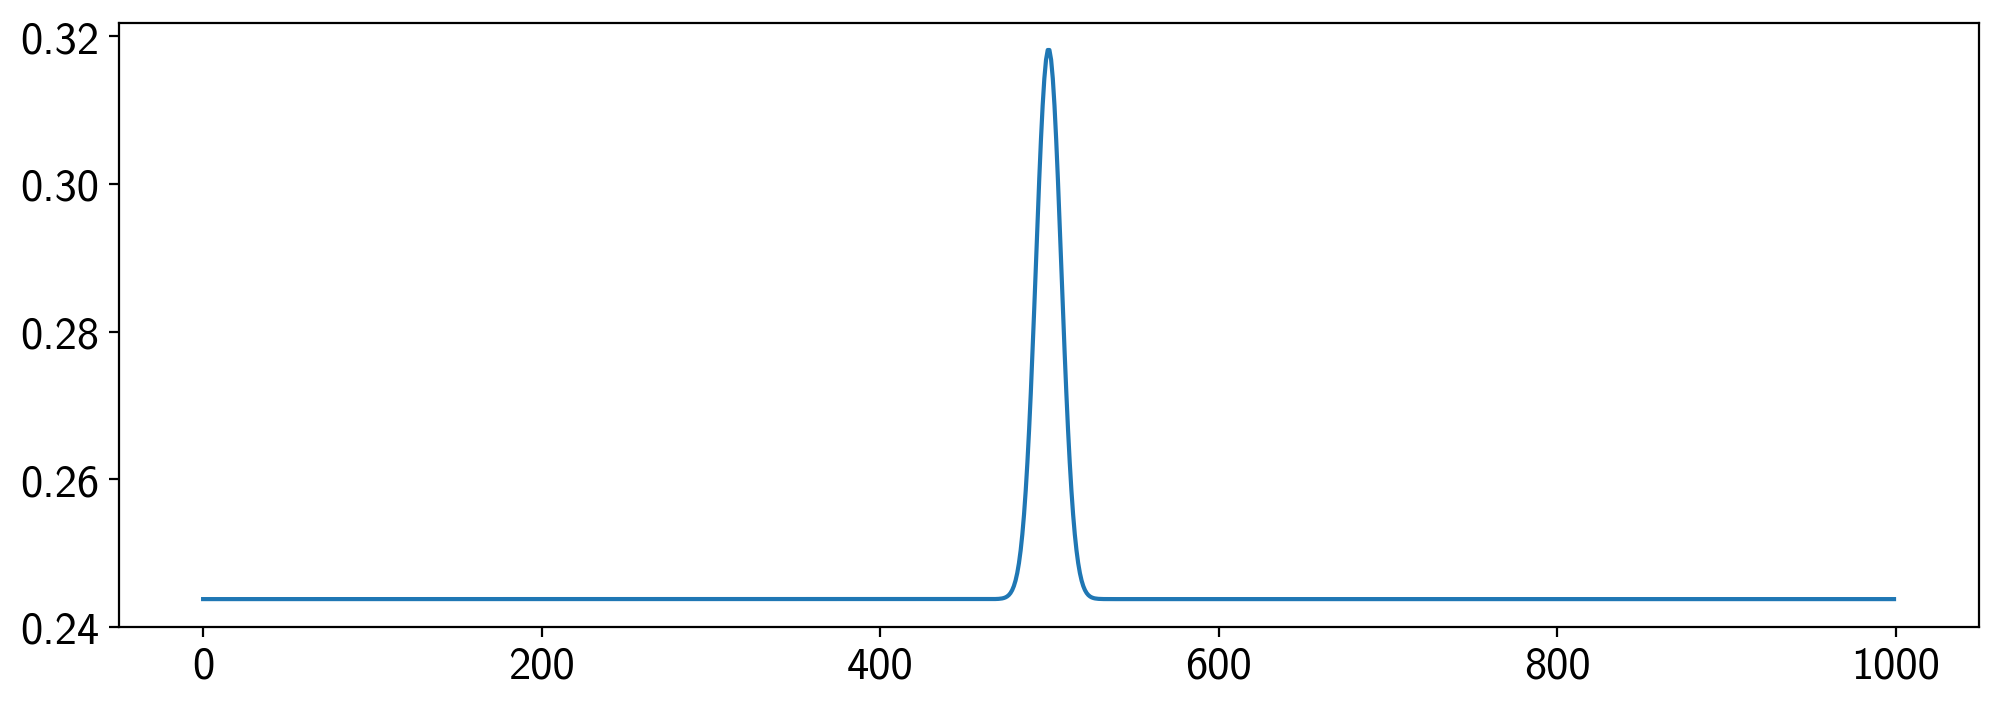

In [120]:
plt.plot(map_s.intensity().T)

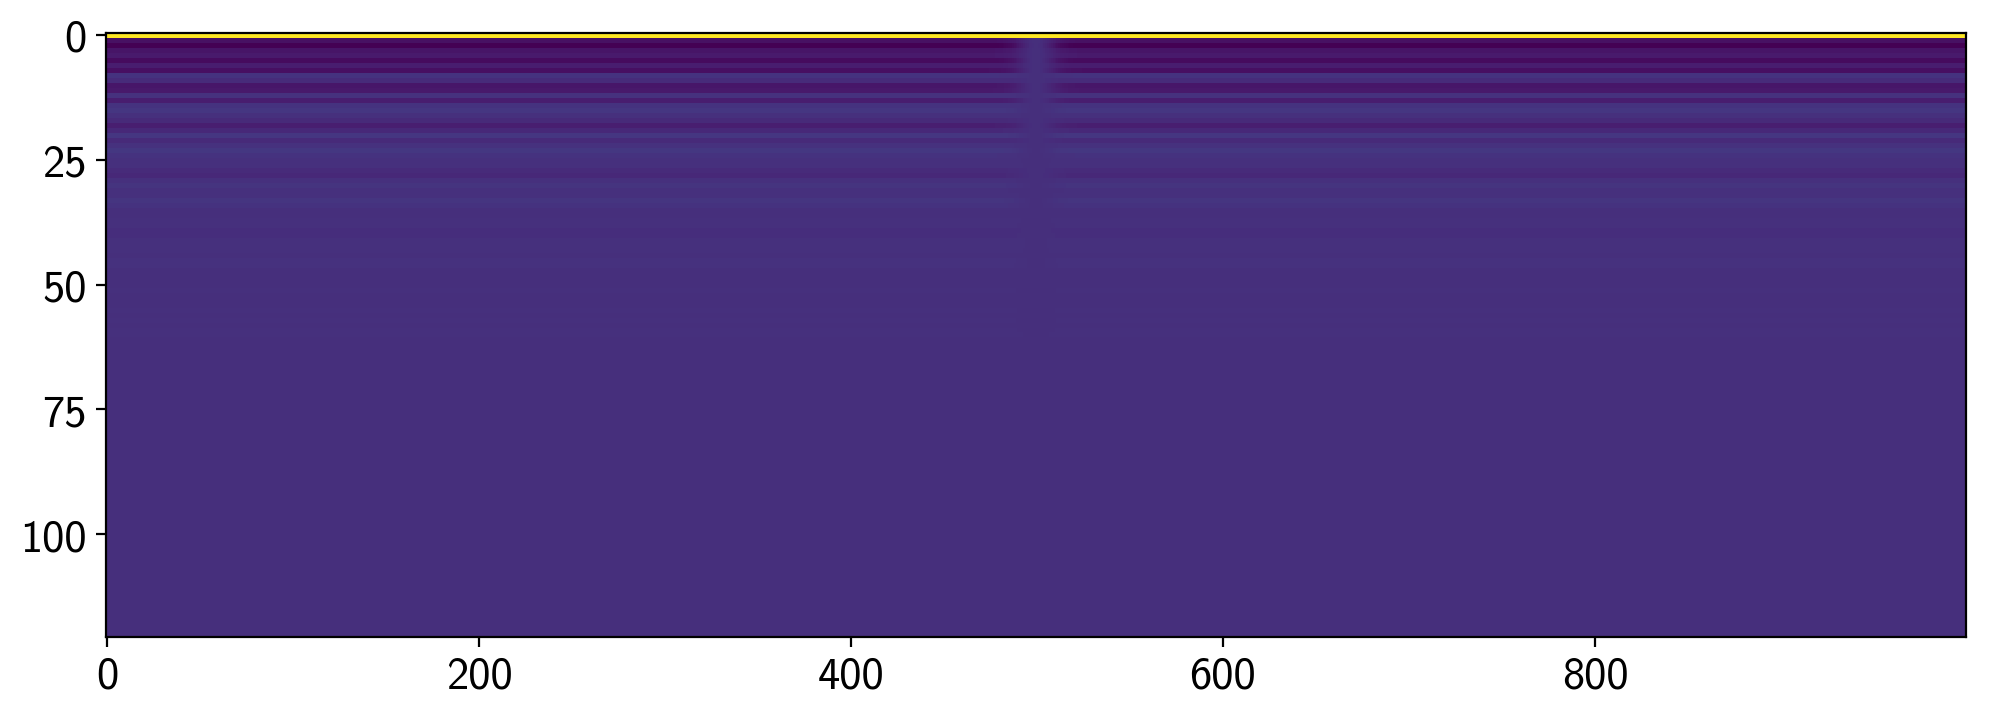

In [125]:
plt.imshow(map_s.y, aspect="auto")